In [4]:
from constraints import *
from helper import *

# Van Der Pol

Van Der Pol Oscillator (discretized) dynamics:

$x_{t+1} = -y_t \Delta_t + x_t  $         
$y_{t+1} = -(u_t(1-x_t^2)y_t - x_t) \Delta_t + y_t$

### Forward Euler

In [5]:
def forwardEulerVP(init,constants,plot=False):
    x0, y0 = init[0], init[1]
    
    T = constants["T"]
    del_t = constants["del_t"]
    
    xs, ys = [x0], [y0]
    x,y = x0, y0
    for t in range(T):
        u = 1.0
        x, y = x-y*del_t, y - (u*(1-x**2)*y - x)*del_t
        xs.append(x)
        ys.append(y)
        
    if plot:
        plt.figure()
        plt.plot(xs, ys, '*')
        
    traj = [(xs[i],ys[i]) for i in range(len(xs))]
    return traj

### Initial Setup

In [6]:
# horizon and forward Euler time step
T = 15
del_t = -0.1

# box constraints for initial state
x0 = 1
y0 = 1
x_dev = 0.01
y_dev = 0.01

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0

# constants for dynamics
constants = {"T":T, "del_t":del_t,
             "x0":x0, "y0":y0}

x_range, y_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev]

# Use convex constraints (linear underestimator/overestimator based on convexity properties) where approapriate
use_convex = True

### Fast Reachable Set Computation

In [12]:
areas_fast = []
times_fast = []
boxes_fast = []

x0_bounds = BoxConstraints(x_lw_b,x_up_b)
y0_bounds = BoxConstraints(y_lw_b,y_up_b)
u0_bound = BoxConstraints(0.2,1.0)
var_bounds = {"x":x0_bounds, "y":y0_bounds, "u":u0_bound}

x_0_coeffs = {"x":1, "y":0, "u":0, "_const":0}
x_0 = LinearConstraints(Line(x_0_coeffs.copy()), Line(x_0_coeffs.copy()),var_bounds)

y_0_coeffs = {"x":0, "y":1, "u":0, "_const":0}
y_0 = LinearConstraints(Line(y_0_coeffs.copy()), Line(y_0_coeffs.copy()),var_bounds)

u_0_coeffs = {"x":0, "y":0, "u":1, "_const":0}
u_0 = LinearConstraints(Line(u_0_coeffs.copy()), Line(u_0_coeffs.copy()),var_bounds)

for t in range(constants["T"]):
    tt = time.time()
    box_x, box_y = x_0.eval_box(), y_0.eval_box()
    areas_fast.append((box_x.upper-box_x.lower)*(box_y.upper-box_y.lower))
    boxes_fast.append(([box_x.lower,box_x.upper],[box_y.lower,box_y.upper]))
    
    x_temp = y_0.mult_const(constants["del_t"]*(-1)).add(x_0)
    
    x_squared = None
    if use_convex:
        fn = lambda v: v["x"]**2
        gradient_fn = lambda v: {"x":2*v["x"]}
#         var_map = {"x":x_0}
#         x_squared = ConvexConstraints(var_bounds, fn, gradient_fn, var_map, convex=True, point_grad=None)
        x_squared = ConvexConstraints({"x":x_0},var_bounds, fn, gradient_fn, convex=True)
    else:
        x_squared = x_0.power(2)
    
    y_temp = x_squared.mult_const(-1).add_const(1).mult(u_0).mult(y_0).add(x_0.mult_const(-1)).mult_const(constants["del_t"]*(-1)).add(y_0)
    x_0, y_0 = x_temp, y_temp
    
    tt = time.time() - tt
    times_fast.append(tt)

### CVX Reachable Set Computation

In [13]:
def one_minus_x_squared(w, x, x_bounds):
    a,b = x_bounds # lower, upper bound
    c = []
    c.append(w >= a*b - (a+b)*x + 1)
    c.append(w <= 1 + ((a+b)**2)/4 - (a+b)*x)
    return c

In [14]:
def VanDerPolConstraints(T=1,variables=[],constraints=[],control_bounds=[],Npast=0, use_convex=False, constants={}):
    times = []
    ss = []
    boxes = []
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)
        xL,xU = x_bounds
        yL,yU = y_bounds
        boxes.append(([xL,xU],[yL,yU]))
        ss.append((xU-xL)*(yU-yL))

        u = variables[t]["u"]
        u_bounds = control_bounds[t]
        constraints.append(u <= u_bounds[1])
        constraints.append(u >= u_bounds[0])
        
        if use_convex:
            v = variables[t]["v"]
            constraints.extend(one_minus_x_squared(v,x,x_bounds))
            v_bounds = bounds(v,constraints,Npast=Npast)
        else:
            n = variables[t]["n"]
            constraints.extend(McCormick(n,x,x,x_bounds,x_bounds))

            v = variables[t]["v"]
            constraints.append(v == 1 - n)
            v_bounds = bounds(v,constraints,Npast=Npast)
        

        w = variables[t]["w"]
        constraints.extend(McCormick(w,y,v,y_bounds,v_bounds))
        w_bounds = bounds(w,constraints,Npast=Npast)        

        z = variables[t]["z"]
        constraints.extend(McCormick(z,u,w,u_bounds,w_bounds)) 

        y_new = variables[t+1]["y"]
        constraints.append(y_new == -1*z*del_t + x*del_t + y)

        x_new = variables[t+1]["x"]
        constraints.append(x_new == -y*del_t + x)

        tt = time.time() - tt
        times.append(tt)
    
    return variables,constraints, times, ss,boxes

In [15]:
variables = [{"u":cvxpy.Variable(),"x":cvxpy.Variable(),"y":cvxpy.Variable(),"z":cvxpy.Variable(),"w":cvxpy.Variable(),"v":cvxpy.Variable(),"n":cvxpy.Variable()} for t in range(T+1)]

# plt.figure(2)
# plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')

x = variables[0]["x"]
y = variables[0]["y"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)

control_bounds = [(0.2,1.0) for t in range(T)]
#control_bounds = [(2.0,2.5),(2.0,2.5),(2.0,2.5),(2.0,2.5)]

variables,constraints,times_convex,areas_convex,boxes_convex = VanDerPolConstraints(T,variables,constraints,control_bounds,use_convex=use_convex,constants=constants)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)

Academic license - for non-commercial use only


### Visualizations

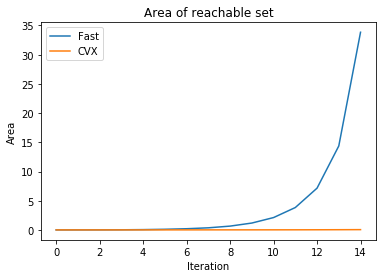

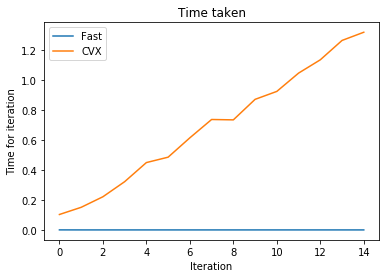

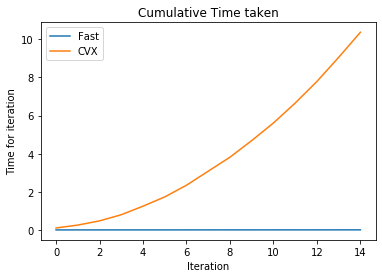

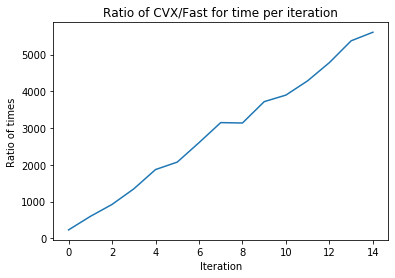

In [16]:
convex_res = {"area":areas_convex, "time":times_convex}
fast_res = {"area":areas_fast, "time":times_fast}
visualize(convex_res,fast_res)

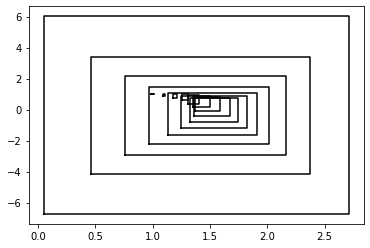

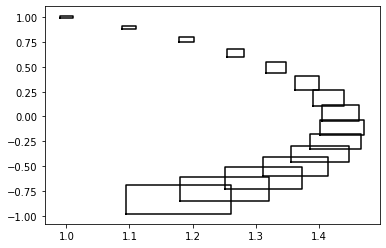

In [17]:
plot_boxes_2d(boxes_fast)
plot_boxes_2d(boxes_convex)

### Verify Boxes Found are Valid via Sampling

Sample the space of initial conditions and forward propogate trajectories using the forward Euler method to validate if trajectories remain within boxed sets found via both the CVX approach or the fast approach.

NOTE: Forward euler assumes constant control at $u_t \equiv 1$. Should change in the future.

True
True


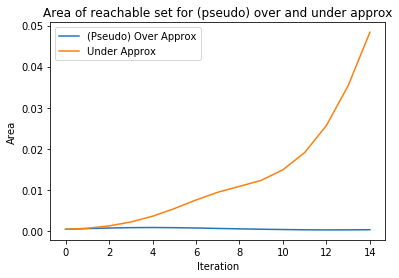

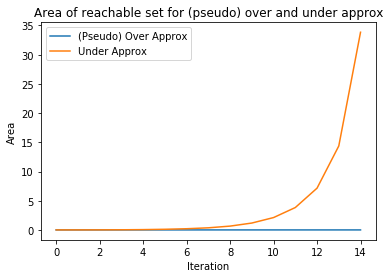

In [18]:
num_samples = 10000
print(verify_valid_boxes(boxes_convex,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerVP,constants=constants))
print(verify_valid_boxes(boxes_fast,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerVP,constants=constants))